In [39]:
from urllib.request import urlretrieve
import gzip
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from sklearn.manifold import TSNE

In [40]:
np.random.seed(42)

In [41]:
def download():
    labels_file = 't10k-labels-idx1-ubyte.gz'
    images_file = 't10k-images-idx3-ubyte.gz'
    urlretrieve('http://yann.lecun.com/exdb/mnist/' + labels_file, labels_file)
    urlretrieve('http://yann.lecun.com/exdb/mnist/' + images_file, images_file)
   
    with gzip.open(labels_file, 'rb') as buf:
        labels = np.frombuffer(buf.read(), np.uint8, offset=8)
    with gzip.open(images_file, 'rb') as buf:
        images = np.frombuffer(buf.read(), np.uint8, offset=16).reshape(-1, 28, 28)
        
    return images, labels

def create_mnist():
    images, labels = download()
    mnist = [
        np.array([images[i] for i in range(*labels.shape) if labels[i] == 0]),
        np.array([images[i] for i in range(*labels.shape) if labels[i] == 1]),
        np.array([images[i] for i in range(*labels.shape) if labels[i] == 2]),
        np.array([images[i] for i in range(*labels.shape) if labels[i] == 3]),
        np.array([images[i] for i in range(*labels.shape) if labels[i] == 4]),
        np.array([images[i] for i in range(*labels.shape) if labels[i] == 5]),
        np.array([images[i] for i in range(*labels.shape) if labels[i] == 6]),
        np.array([images[i] for i in range(*labels.shape) if labels[i] == 7]),
        np.array([images[i] for i in range(*labels.shape) if labels[i] == 8]),
        np.array([images[i] for i in range(*labels.shape) if labels[i] == 9])
    ]
    for m in mnist:
        np.random.shuffle(m)
    return mnist

In [42]:
mnist = create_mnist()

In [43]:
def simplify(arr):
    return np.array([[y.sum() for y in x] for x in arr], dtype=np.float64)

def create_templates(mnist, num=10, dim=14):
    simple = []
    for m in mnist:
        assert num <= len(m)
    
    for m in mnist:
        simple.append(simplify(m[:num:]))

    simple = np.array(simple)
    simple -= simple.mean()
    simple /= simple.std()
    simple -= simple.min()

    x = np.linspace(0, 28, dim)
    xp = np.linspace(0, 28, 28)
    template = np.array([[np.interp(x, xp, fp) for fp in s] for s in simple])

    mean = np.array([t.sum(axis=0)/num for t in template])
    
    return template, mean

def create_mse_table(data):
    table = []
    d = data.shape[2]
    l = data.shape[1]

    for n0 in data:
        rows = []
        for i in n0:
            row = []
            for n1 in data:
                sum = 0
                for j in n1:
                    sum += ((((j - i)**2)).sum()/d)
                row.append(sum/l)
            rows.append(row)
        rows = np.array(rows)
        table.append(rows.sum(axis=0)/len(rows))
    return np.array(table)

In [44]:
def plot_mnist(mnist):
    fig, axs = plt.subplots(ncols=10, nrows=1, figsize=[16, 16], dpi=60, layout='constrained')
    for i in range(len(mnist)):
        axs[i].set_title('label=' + str(i), fontsize='xx-large')
        axs[i].imshow(mnist[i][0], cmap='gray')
        axs[i].axis('off')
    plt.show()

def plot_templates(templates, title='One dimensional MNIST'):
    dim = templates.shape[2]
    y = np.linspace(0, templates.max(), dim)
    
    fig, axs = plt.subplots(ncols=10, nrows=1, dpi=60, figsize=[16, 2.5], layout='constrained')
    fig.suptitle(title, fontsize=16)
    for i in range(templates.shape[0]):
        x = templates[i][0]
        axs[i].set_title('label=' + str(i), fontsize='xx-large')
        axs[i].plot(x, y, 'k-', linewidth=2)
    # plt.xticks([], []), plt.yticks([], [])
    plt.show()

def plot_mse_tables(tables, title='MSE Tables', labels=[]):
    n = tables.shape[0]
    
    fig, axs = plt.subplots(ncols=n, figsize=[16, 4], dpi=60, layout='constrained')
    fig.suptitle(title)
    for i in range(n):
        if labels:
            axs[i].set_title(labels[i])
        img = axs[i].imshow(tables[i])
        fig.colorbar(img, location='bottom')
    
    plt.xticks([i for i in range(10)], [i for i in range(10)])
    plt.yticks([i for i in range(10)], [i for i in range(10)])
    plt.show()

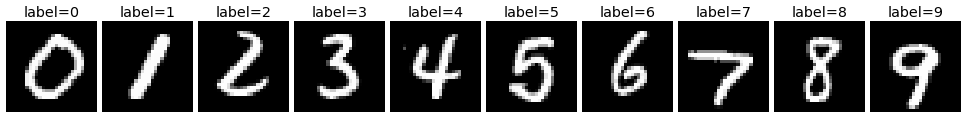

In [45]:
plot_mnist(mnist)

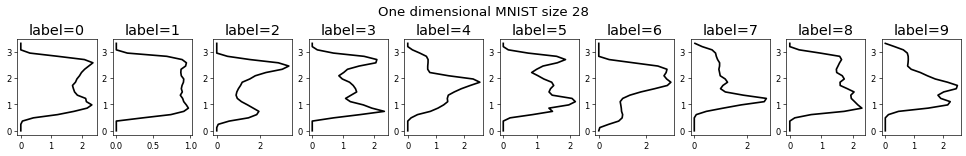

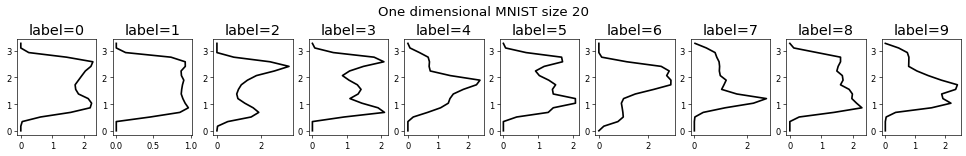

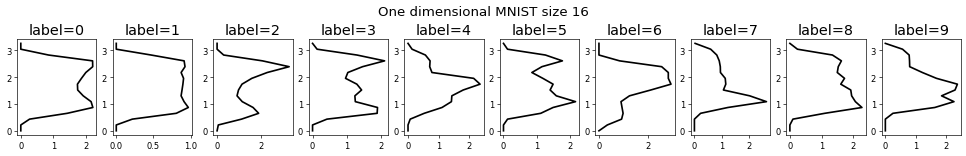

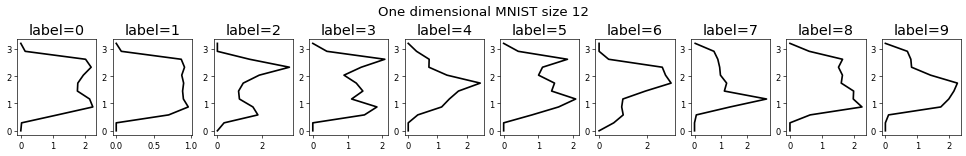

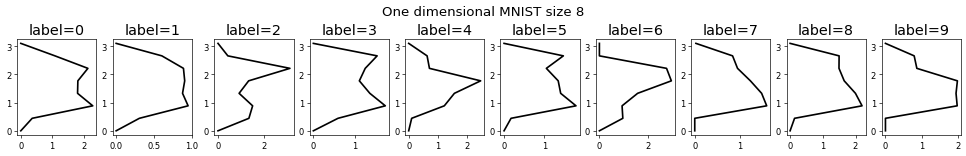

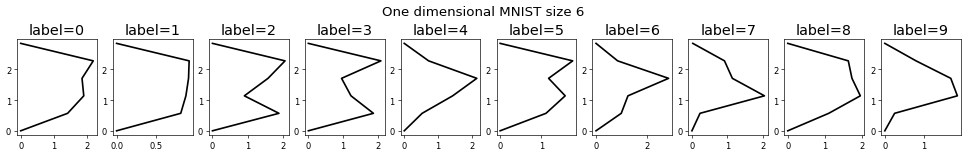

In [46]:
dims = [28, 20, 16, 12, 8, 6]
tables = []
for d in dims:
    t, m = create_templates(mnist, num=10, dim=d)
    tables.append(create_mse_table(t))
    # plot_templates(t, title='One dimensional MNIST size ' + str(d))
    plot_templates(m.reshape(10, 1, -1), title='One dimensional MNIST size ' + str(d))

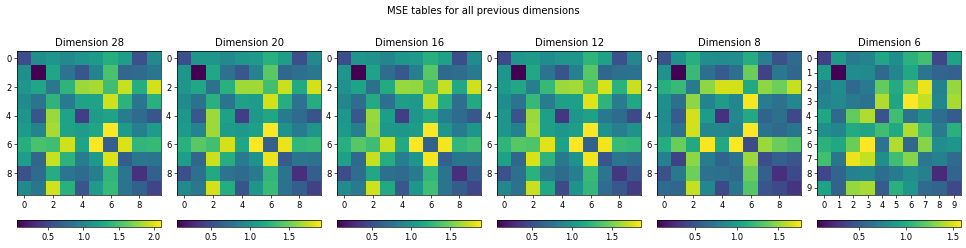

In [47]:
labels = ['Dimension ' + str(i) for i in dims]
plot_mse_tables(np.array(tables), title='MSE tables for all previous dimensions', labels=labels)

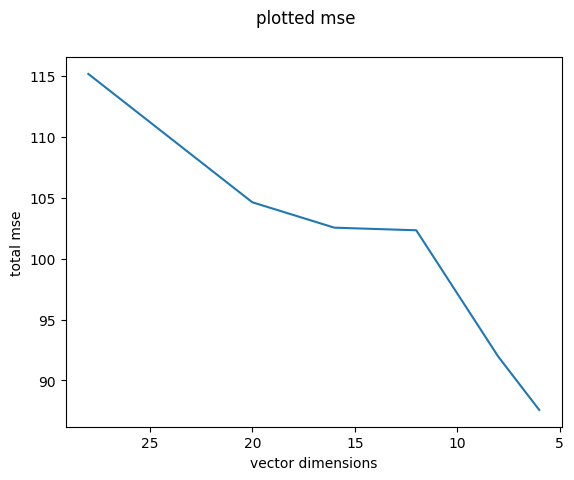

In [48]:
fig, ax = plt.subplots()
fig.suptitle('plotted mse')
ax.plot([d for d in dims], [t.sum() for t in tables])
ax.set_xlabel('vector dimensions')
ax.set_ylabel('total mse')
ax.invert_xaxis()
plt.show()

In [49]:
def pad(x, p):
    return np.concatenate([x, np.zeros(p)])

def scale(x, range):
    return x * (1 + range * np.random.rand() - 0.5)

def translate(x, range):
    t = int(np.random.choice(range))
    return np.concatenate([x[-t:], x[:-t]])

def add_noise(x, scale):
    r = scale * np.random.randn(*x.shape)
    return gaussian_filter(r, 2)

def transform(x, padd, scale_coeff, max_translation, noise):
    x = pad(x, padd)
    x = scale(x, scale_coeff)
    x = translate(x, max_translation)
    mask = x != 0
    x = mask*x + (1 - mask)*add_noise(x, noise)
    return x

In [50]:
padd = 32
scale_coeff = 0.4
max_translation = 32
noise = 0.3

In [51]:
templates, m = create_templates(mnist, num=1, dim=8)
copy = templates

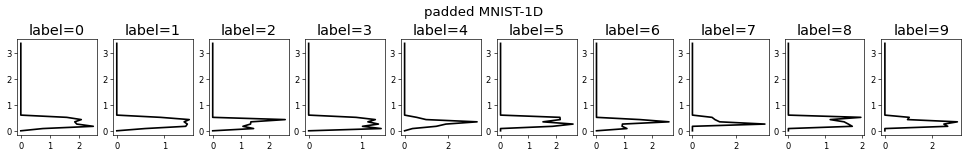

In [52]:
examples = []
for t in copy:
    examples.append(pad(t[0], padd))
copy = np.array(examples).reshape(10, 1, -1)
plot_templates(copy, title='padded MNIST-1D')

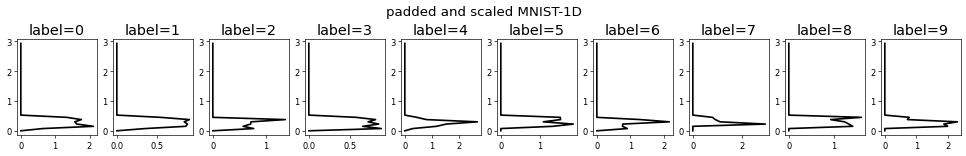

In [53]:
examples = []
for t in copy:
    examples.append(scale(t[0], scale_coeff))
copy = np.array(examples).reshape(10, 1, -1)
plot_templates(copy, title='padded and scaled MNIST-1D')

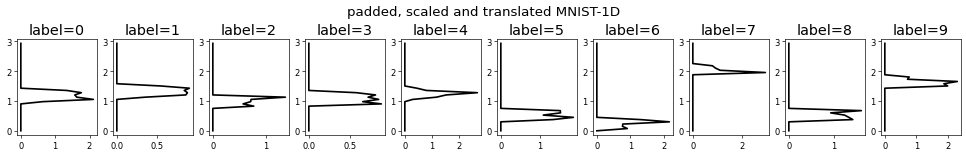

In [54]:
examples = []
for t in copy:
    examples.append(translate(t[0], max_translation))
copy = np.array(examples).reshape(10, 1, -1)
plot_templates(copy, title='padded, scaled and translated MNIST-1D')

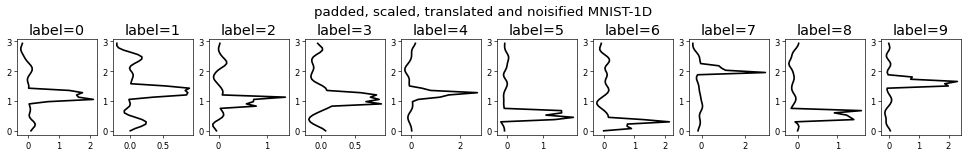

In [55]:
examples = []
for t in copy:
    mask = t[0] != 0
    examples.append(mask*t[0] + (1 - mask)*add_noise(t[0], noise))
copy = np.array(examples).reshape(10, 1, -1)
plot_templates(copy, title='padded, scaled, translated and noisified MNIST-1D')

In [56]:
def create_y(i):
    a = np.zeros(10)
    a[i] = 1.0
    return a

def create_mnist1d(templates, samples=5, padd=32, scale_coeff=0.4, max_translation=32, noise=0.3, split_ratio=0.7):
    t = []
    for temp in templates:
        for _ in range(samples):
            for v in temp:
                t.append(transform(v, padd, scale_coeff, max_translation, noise))
    
    x = np.array(t)
    x -= x.min()
    x /= x.max()
    y = np.array([create_y(i) for i in range(10) for j in range(templates.shape[1] * samples)])

    # https://stackoverflow.com/questions/4601373/better-way-to-shuffle-two-numpy-arrays-in-unison
    assert len(x) == len(y)
    p = np.random.permutation(len(x))
    x = x[p]
    y = y[p]

    split = int(len(x) * split_ratio)
    x_train = x[:split]
    y_train = y[:split]
    x_test = x[split:]
    y_test = y[split:]
    
    return x_train, y_train, x_test, y_test

In [57]:
t, m = create_templates(mnist, num=10, dim=8)
x_train, y_train, x_test, y_test = create_mnist1d(t, samples=100)

In [58]:
np.shape(x_train)

(7000, 40)

In [59]:
model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=(40, 1)))
model.add(tf.keras.layers.Conv1D(filters=16, kernel_size=3, strides=1, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D())
model.add(tf.keras.layers.Conv1D(filters=1024, kernel_size=3, strides=1, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D())
model.add(tf.keras.layers.MaxPooling1D())
model.add(tf.keras.layers.MaxPooling1D())
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(500, activation='relu'))
model.add(tf.keras.layers.Dense(10, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 38, 16)            64        
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 19, 16)           0         
 1D)                                                             
                                                                 
 conv1d_3 (Conv1D)           (None, 17, 1024)          50176     
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 8, 1024)          0         
 1D)                                                             
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 4, 1024)          0         
 1D)                                                             
                                                      

In [60]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [61]:
h = model.fit(x_train, y_train, batch_size=64, epochs=10, validation_data=(x_test, y_test))

Epoch 1/10
110/110 [==============================] - 3s 17ms/step - loss: 2.0362 - accuracy: 0.2471 - val_loss: 1.6394 - val_accuracy: 0.4203
Epoch 2/10
110/110 [==============================] - 1s 13ms/step - loss: 1.3211 - accuracy: 0.5166 - val_loss: 1.0892 - val_accuracy: 0.5907
Epoch 3/10
110/110 [==============================] - 1s 13ms/step - loss: 0.9770 - accuracy: 0.6321 - val_loss: 0.9513 - val_accuracy: 0.6173
Epoch 4/10
110/110 [==============================] - 1s 13ms/step - loss: 0.8344 - accuracy: 0.6826 - val_loss: 0.7722 - val_accuracy: 0.7230
Epoch 5/10
110/110 [==============================] - 1s 13ms/step - loss: 0.7165 - accuracy: 0.7293 - val_loss: 0.6488 - val_accuracy: 0.7650
Epoch 6/10
110/110 [==============================] - 1s 13ms/step - loss: 0.5930 - accuracy: 0.7847 - val_loss: 0.5501 - val_accuracy: 0.8047
Epoch 7/10
110/110 [==============================] - 1s 13ms/step - loss: 0.5243 - accuracy: 0.8107 - val_loss: 0.5222 - val_accuracy: 0.8073

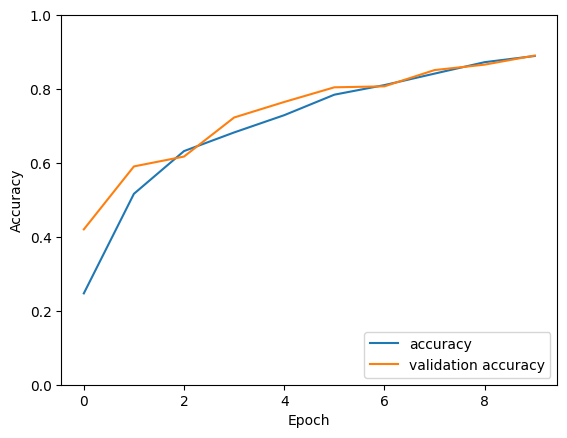

In [62]:
plt.plot(h.history['accuracy'], label='accuracy')
plt.plot(h.history['val_accuracy'], label = 'validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.0, 1])
plt.legend(loc='lower right')

In [63]:
def plot_confusion(y, predictions, labels):
    confusion = confusion_matrix([p.argmax() for p in y], [p.argmax() for p in predictions])
    
    # copied from: https://matplotlib.org/stable/gallery/images_contours_and_fields/image_annotated_heatmap.html
    fig, ax = plt.subplots()
    im = ax.imshow(confusion)
    
    ax.set_xticks(np.arange(len(labels)), labels=labels)
    ax.set_yticks(np.arange(len(labels)), labels=labels)
    
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    
    for i in range(len(labels)):
        for j in range(len(labels)):
            text = ax.text(j, i, confusion[i, j], ha="center", va="center", color="b")
            
    ax.set_title("Confusion matrix")
    fig.tight_layout()
    plt.show()

def plot_tsne(title, x, y, p=30, iter=500):
    tsne = TSNE(random_state = 42, n_components=2,verbose=0, perplexity=p, n_iter=iter).fit_transform(x)
    
    plt.scatter(tsne[:, 0], tsne[:, 1], s= 5, c=[p.argmax() for p in y], cmap='Spectral')
    plt.gca().set_aspect('equal', 'datalim')
    plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
    plt.title(title, fontsize=24);

In [64]:
x = np.concatenate((x_train, x_test))
y = np.concatenate((y_train, y_test))

In [65]:
predictions = model.predict(x)

313/313 [==============================] - 1s 3ms/step


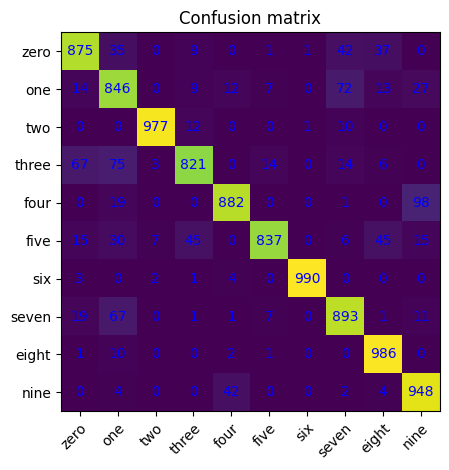

In [66]:
plot_confusion(y, predictions, ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine'])

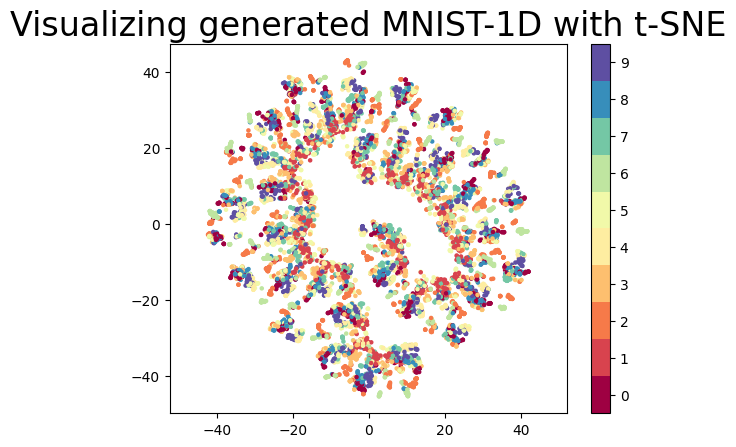

In [67]:
plot_tsne('Visualizing generated MNIST-1D with t-SNE', x, y, p=30, iter=500)

In [68]:
x *= 255.0
x = x.astype(np.uint8)
y = np.array([i.argmax() for i in y]).astype(np.uint8)

In [69]:
with open('mnist-1d.npy', 'wb') as f:
    np.save(f, x)
    np.save(f, y)